## Time Series Forecasting Using Pyro

1. [Dataset](#Lynx-Dataset)
2. [Seasonal Global Trend Models](#Seasonal-Global-Trend-Models)
3. [Inference Using Automatic Variational Inference](#Inference-Using-Automatic-Variational-Inference)
    - [Model 1: Noise is time invariant](#Model-1:-Noise-is-time-invariant-(tau_var-=-0))
    - [Modeling dual seasonality](#Model-dual-seasonality-(use-the-higher-S=38))
    - [Model 1.1: Change prior to smooth non-seasonal component](#Model-1.1:-Change-prior-to-smooth-non-seasonal-component)
    - [Model 2: Noise varies with time](#Model-2:-Noise-varies-with-time-(tau_var-is-non-zero))
3. [Inference Using MCMC](#Inference-Using-MCMC)
    - [Damping the prediction function](#Damping-the-prediction-function)
4. [Inference Using SVGD](#Inference-Using-SVGD)

In [1]:
%reset -sf

In [2]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
from pyro.contrib.autoguide import *
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
import pyro.optim as optim
import pyro.poutine as poutine
import seaborn as sns
import torch

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)

print(pyro.__version__)
print(torch.__version__)

0.3.4+f6553bef
1.2.0


## Lynx Dataset

In [3]:
URL = "https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/datasets/lynx.csv"
lynx = pd.read_csv(URL, index_col=0)
lynx[:20]

,time,value
1,1821,269
2,1822,321
3,1823,585
4,1824,871
5,1825,1475
6,1826,2821
7,1827,3928
8,1828,5943
9,1829,4950
10,1830,2577


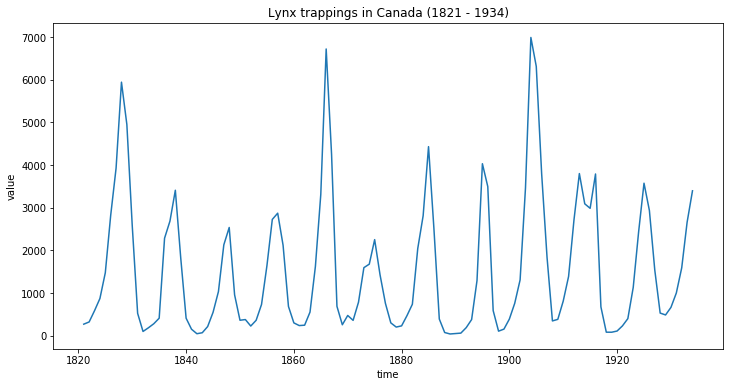

In [4]:
y = torch.tensor(lynx["value"].values, dtype=torch.float32)
y_train = y[:-30]
sns.lineplot('time', 'value', data=lynx).set_title('Lynx trappings in Canada (1821 - 1934)');

## Seasonal Global Trend Models

Given some data, $y$ with seasonality $S$; at time $t$, the parameters of the SGT model are updated as follows, to generate the predicted $\tilde{y}_{t+1}$. $m(t)$ is the index of the data point that is one season away from the current time $t$.

$$
\begin{align}
\tilde{y}_{t+1} & \sim t(\nu, \hat{y}_{t+1}, \hat{\sigma}_{t+1}) \\
\hat{y}_{t+1} & = (l_t + \gamma * l_{t}^{\tau_{trend}}) * s_{m(t+1)} \\
\hat{\sigma}_{t+1} &= \sigma \hat{y}_{t+1}^{\tau_{var}} \\
l_t &= \alpha \frac{y_t}{s_{m(t)}} + (1 - \alpha) * l_{t-1} \\
s_t &= \beta \frac{y_t}{l_t} + (1 - \beta) s_{m(t)} \\
\end{align}
$$

We place appropriate priors on $\nu$, $\alpha$, $\beta$, $\gamma$, $\sigma$, $\tau_{trend}$ and $\tau_{var}$.

## Inference Using Automatic Variational Inference

### Model 1: Noise is time invariant (tau_var = 0)

In [5]:
def model_sgt_1(y, seasonality, predict_fn=None, predict_ahead=0):
    """
    A bayesian model for time series forecasting using Seasonal Global Trend (SGT).
    Note that `tau_var` is assumed to be 0.
    """
    if predict_fn is None:
        predict_fn=model_sgt_predict
    S = seasonality
    nu = pyro.sample('nu', dist.Uniform(2, 20))
    sigma = pyro.sample('sigma', dist.HalfCauchy(20.))
    alpha = pyro.sample('alpha', dist.Beta(2., 2.)) 
    beta = pyro.sample('beta', dist.Beta(2., 2.))
    gamma = pyro.sample('gamma', dist.Beta(2., 2.))
    pow_trend = pyro.sample('pow_trend', dist.HalfNormal(0.5))
    obs_window = pyro.plate('obs_window', len(y))
    s = [torch.ones_like(alpha)] * len(y)
    l = [torch.zeros_like(alpha)] * len(y)
    l[0].fill_(y[0])
    y_hat = y.new_zeros((len(y),) + alpha.shape)
    y_hat[0].fill_(y[0])
    for i in range(1, len(y)):
        seasonality_idx = get_seasonality_lookup_idx(i-1, S, i)
        s_i = s[seasonality_idx]
        assert (s_i > 0).all()
        l[i] = alpha * (y[i] / s_i) + (1 - alpha) * l[i - 1]
        assert (l[i] > 0).all(), "alpha: {}".format(alpha)
        s[i] = beta * (y[i] / l[i]) + (1 - beta) * s_i
        y_hat[i] = (l[i - 1] + gamma * l[i - 1] ** pow_trend) * s_i
        
    with obs_window:
        pyro.sample('y', dist.StudentT(nu, y_hat, sigma), obs=y)
        
    if predict_ahead > 0:
        predict_fn(gamma, pow_trend, nu, sigma, l, s, S, predict_ahead)

In [6]:
def get_seasonality_lookup_idx(num_observed, S, idx):
    """
    Based on the the seasonality `S` and number of observed data points,
    return the index of the last observed data point that is one or more 
    seasons away from idx.
    
    e.g. 
    
    S=5, num_observed=11, idx=12, return -> 7
    S=5, num_observed=11, idx=18, return -> 8
    """
    if idx < S:
        return idx
    lookback = 1
    window_start = (int(idx / S) - lookback) * S
    lookup_idx = window_start + idx % S
    while lookup_idx >= num_observed:
        lookback = lookback + 1
        window_start = (int(idx / S) - lookback) * S
        lookup_idx = window_start + idx % S
    return lookup_idx

In [7]:
def model_sgt_predict(gamma, pow_trend, nu, sigma, l, s, S, predict_ahead=60, pow_var=0.):
    """
    Predict `predict_ahead` time steps forward given SGT parameters.
    """
    pred_window = pyro.plate('pred_window', predict_ahead)
    obs_window = pyro.plate('obs_window_pred', len(s))
    y_pred = y.new_zeros((predict_ahead,) + gamma.shape)
    for j in range(predict_ahead):
        i = len(s) + j
        s_i = s[get_seasonality_lookup_idx(len(s), S, i)]
        l_i = l[len(s) - 1]
        y_pred[j] = (l_i + j * l_i ** pow_trend) * s_i
    with obs_window:
        pyro.sample('s', dist.Delta(torch.stack(s, -1)))  # For plotting
        pyro.sample('l', dist.Delta(torch.stack(l, -1)))  # For plotting
    sigma_hat = sigma * y_pred ** pow_var
    with pred_window:
        pyro.sample('y_pred', dist.StudentT(df=nu, loc=y_pred, scale=sigma_hat))

In [8]:
pyro.clear_param_store()
pyro.set_rng_seed(1)
guide = AutoDiagonalNormal(model_sgt_1)
opt = optim.Adam({'lr': 0.05})

svi = SVI(model_sgt_1, guide, opt, loss=Trace_ELBO())
S = 10  # Use seasonality of 10

for i in range(800):
    loss = svi.step(y_train, S)
    if i % 100 == 0:
        print('ELBO loss: {}'.format(loss))
print('ELBO loss: {}'.format(loss))

ELBO loss: 1450.8923826217651
ELBO loss: 708.4456034898758
ELBO loss: 707.0878501534462
ELBO loss: 708.9420905709267
ELBO loss: 720.2607739567757
ELBO loss: 708.0286077260971
ELBO loss: 708.2992467880249
ELBO loss: 709.1139467954636
ELBO loss: 707.388730764389


In [9]:
def predict(model, guide, y, *args, future_steps=30, num_samples=100, predict_fn=model_sgt_predict):
    """
    Generate `num_samples` predictions by sampling the parameters for the
    time series model from the approximate posterior.    
    """
    preds = []
    l, s = [], []
    for i in range(num_samples):
        guide_trace = poutine.trace(guide).get_trace(y, *args, 
                                                     predict_ahead=future_steps,
                                                     predict_fn=predict_fn)
        model_trace = poutine.trace(poutine.replay(model, guide_trace)).get_trace(y, *args, 
                                                                                  predict_ahead=future_steps)
        preds.append(torch.cat([model_trace.nodes['y']['value'], model_trace.nodes['y_pred']['value']]))
        l.append(model_trace.nodes['l']['value'])
        s.append(model_trace.nodes['s']['value'])
    return torch.stack(preds), torch.stack(l), torch.stack(s)

In [10]:
num_samples = 500
preds, l, s = predict(model_sgt_1, guide, y_train, S, future_steps=60, num_samples=num_samples)

In [11]:
res1 = lynx.copy()
res1['type'] = 'Actual'
l_samples = np.hstack([l.detach().cpu().numpy(), 
                      np.full((num_samples, len(preds[1]) - len(l[1])), np.nan)
                      ]).flatten()
s_samples = np.hstack([s.detach().cpu().numpy(), 
                       np.full((num_samples, len(preds[1]) - len(s[1])), np.nan)
                      ]).flatten()
df = pd.DataFrame(np.stack([
    np.tile(np.arange(1821, 1821 + len(preds[1])), num_samples), 
    preds.flatten().detach().cpu().numpy(),
    l_samples,
    s_samples,
]).T, columns=['time', 'value', 'l', 's'])
df['type'] = 'Predicted'
res1 = res1.append(df, sort=True)
res1 = res1.astype({'time': 'int32'})

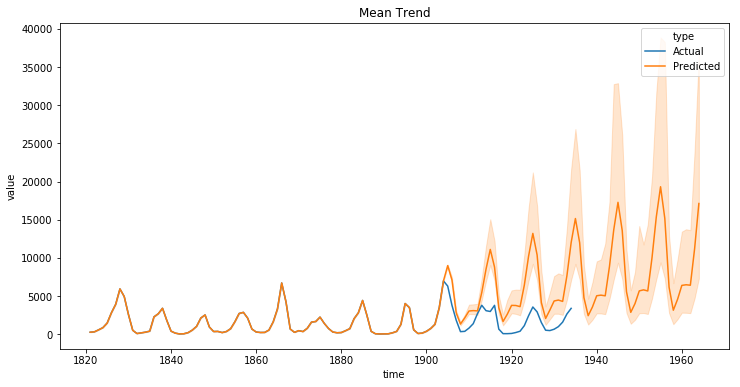

In [12]:
sns.lineplot('time', 'value', hue='type', data=res1).set_title('Mean Trend');

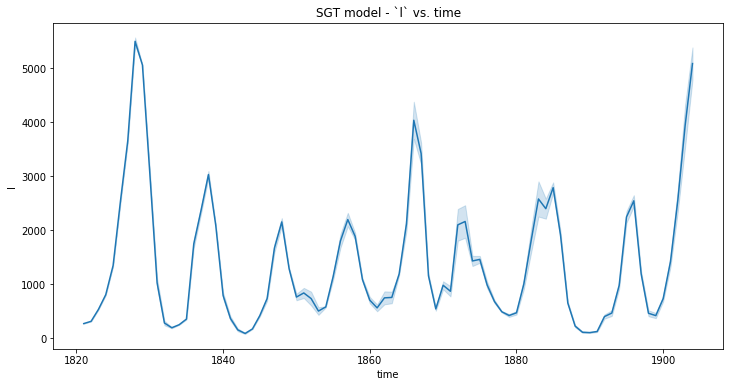

In [13]:
sns.lineplot('time', 'l', data=res1, ci='sd').set_title('SGT model - `l` vs. time');

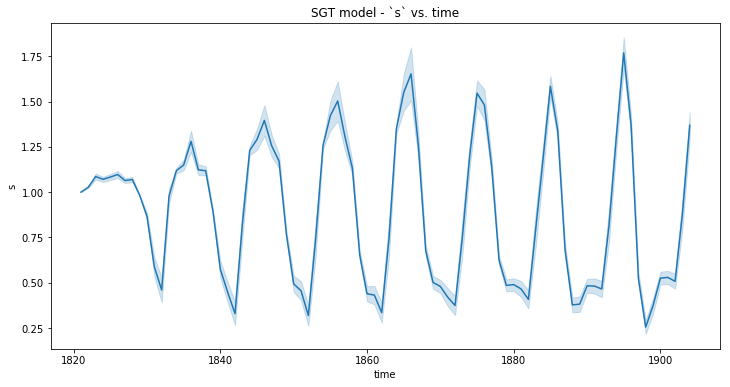

In [14]:
sns.lineplot('time', 's', data=res1, ci='sd').set_title('SGT model - `s` vs. time');

In [15]:
guide.quantiles([0.2, 0.5, 0.8])

{'nu': [tensor(3.0822, grad_fn=<AddBackward0>),
  tensor(4.4978, grad_fn=<AddBackward0>),
  tensor(7.1964, grad_fn=<AddBackward0>)],
 'sigma': [tensor(684.0310, grad_fn=<AddBackward0>),
  tensor(774.6719, grad_fn=<AddBackward0>),
  tensor(877.3237, grad_fn=<AddBackward0>)],
 'alpha': [tensor(0.7826, grad_fn=<ClampBackward>),
  tensor(0.8066, grad_fn=<ClampBackward>),
  tensor(0.8286, grad_fn=<ClampBackward>)],
 'beta': [tensor(0.7845, grad_fn=<ClampBackward>),
  tensor(0.8572, grad_fn=<ClampBackward>),
  tensor(0.9083, grad_fn=<ClampBackward>)],
 'gamma': [tensor(0.2021, grad_fn=<ClampBackward>),
  tensor(0.4192, grad_fn=<ClampBackward>),
  tensor(0.6728, grad_fn=<ClampBackward>)],
 'pow_trend': [tensor(0.1070, grad_fn=<AddBackward0>),
  tensor(0.1594, grad_fn=<AddBackward0>),
  tensor(0.2373, grad_fn=<AddBackward0>)]}

### Model dual seasonality (use the higher S=38)

In [16]:
pyro.clear_param_store()
pyro.set_rng_seed(2)
S = 38
guide = AutoDiagonalNormal(model_sgt_1)
opt = optim.Adam({'lr': 0.05})
svi = SVI(model_sgt_1, guide, opt, loss=Trace_ELBO())

for i in range(1200):
    loss = svi.step(y_train, S)
    if i % 100 == 0:
        print('ELBO loss: {}'.format(loss))
print('ELBO loss: {}'.format(loss))        

ELBO loss: 2924.231234192848
ELBO loss: 1727.4143707752228
ELBO loss: 726.198387503624
ELBO loss: 724.8861444592476
ELBO loss: 729.1427811980247
ELBO loss: 732.8251900076866
ELBO loss: 721.4988940358162
ELBO loss: 722.6755806207657
ELBO loss: 722.6950109004974
ELBO loss: 723.1474885940552
ELBO loss: 725.6476258039474
ELBO loss: 722.1955180168152
ELBO loss: 723.419872045517


In [17]:
num_samples = 500
preds, l, s = predict(model_sgt_1, guide, y_train, S, future_steps=60, num_samples=num_samples)

res2 = lynx.copy()
res2['type'] = 'Actual'
l_samples = np.hstack([l.detach().cpu().numpy(), 
                      np.full((num_samples, len(preds[1]) - len(l[1])), np.nan)
                      ]).flatten()
s_samples = np.hstack([s.detach().cpu().numpy(), 
                       np.full((num_samples, len(preds[1]) - len(s[1])), np.nan)
                      ]).flatten()
df = pd.DataFrame(np.stack([
    np.tile(np.arange(1821, 1821 + len(preds[1])), num_samples), 
    preds.flatten().detach().cpu().numpy(),
    l_samples,
    s_samples,
]).T, columns=['time', 'value', 'l', 's'])
df['type'] = 'Predicted'
res2 = res2.append(df, sort=True)
res2 = res2.astype({'time': 'int32'})

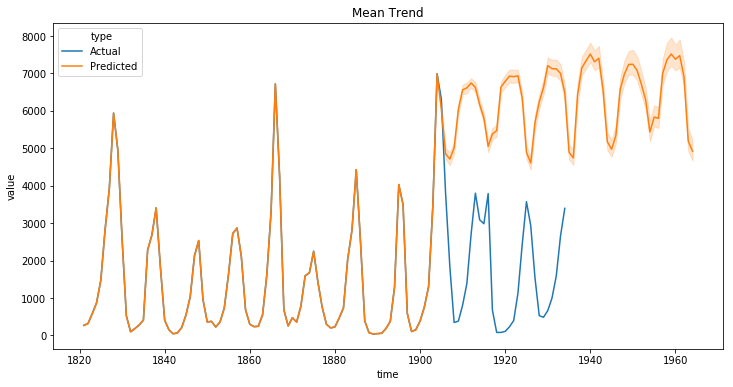

In [18]:
sns.lineplot('time', 'value', hue='type', data=res2).set_title('Mean Trend');

In [19]:
guide.quantiles([0.2, 0.5, 0.8])

{'nu': [tensor(2.7435, grad_fn=<AddBackward0>),
  tensor(3.1712, grad_fn=<AddBackward0>),
  tensor(3.8189, grad_fn=<AddBackward0>)],
 'sigma': [tensor(726.8394, grad_fn=<AddBackward0>),
  tensor(822.9260, grad_fn=<AddBackward0>),
  tensor(931.7151, grad_fn=<AddBackward0>)],
 'alpha': [tensor(0.8578, grad_fn=<ClampBackward>),
  tensor(0.9172, grad_fn=<ClampBackward>),
  tensor(0.9532, grad_fn=<ClampBackward>)],
 'beta': [tensor(0.4478, grad_fn=<ClampBackward>),
  tensor(0.6639, grad_fn=<ClampBackward>),
  tensor(0.8279, grad_fn=<ClampBackward>)],
 'gamma': [tensor(0.2291, grad_fn=<ClampBackward>),
  tensor(0.4478, grad_fn=<ClampBackward>),
  tensor(0.6887, grad_fn=<ClampBackward>)],
 'pow_trend': [tensor(0.1127, grad_fn=<AddBackward0>),
  tensor(0.1725, grad_fn=<AddBackward0>),
  tensor(0.2641, grad_fn=<AddBackward0>)]}

### Model 1.1: Change prior to smooth non-seasonal component

In [20]:
def model_sgt_2(y, seasonality, predict_fn=None, predict_ahead=0):
    """
    SGT model with low alpha to encourage smoothing.
    """
    if predict_fn is None:
        predict_fn = model_sgt_predict
    S = seasonality
    nu = pyro.sample('nu', dist.Uniform(2, 20))
    sigma = pyro.sample('sigma', dist.HalfCauchy(20.))
    # NOTE: prior is changed to bias alpha --> 0.
    alpha = pyro.sample('alpha', dist.Beta(1., 10.))
    beta = pyro.sample('beta', dist.Beta(2., 2.))
    gamma = pyro.sample('gamma', dist.Beta(2., 2.))
    pow_trend = pyro.sample('pow_trend', dist.HalfNormal(0.2))
    obs_window = pyro.plate('obs_window', len(y))
    s = [torch.ones_like(alpha)] * len(y)
    l = [torch.zeros_like(alpha)] * len(y)
    l[0].fill_(y[0])
    y_hat = y.new_zeros((len(y),) + alpha.shape)
    y_hat[0].fill_(y[0])
    for i in range(1, len(y)):
        seasonality_idx = get_seasonality_lookup_idx(i-1, S, i)
        s_i = s[seasonality_idx]
        assert (s_i > 0).all()
        l[i] = alpha * (y[i] / s_i) + (1 - alpha) * l[i - 1]
        assert (l[i] > 0).all(), "alpha: {}".format(alpha)
        s[i] = beta * (y[i] / l[i]) + (1 - beta) * s_i
        y_hat[i] = l[i - 1] + gamma * l[i - 1] ** pow_trend * s_i 
        
    with obs_window:
        pyro.sample('y', dist.StudentT(nu, y_hat, sigma), obs=y)
        
    if predict_ahead > 0:
        predict_fn(gamma, pow_trend, nu, sigma, l, s, S, predict_ahead)

In [21]:
pyro.clear_param_store()
pyro.set_rng_seed(3)
S = 38
guide = AutoDiagonalNormal(model_sgt_2)
opt = optim.Adam({'lr': 0.05})
svi = SVI(model_sgt_2, guide, opt, loss=Trace_ELBO())

for i in range(800):
    loss = svi.step(y_train, S)
    if i % 100 == 0:
        print('ELBO loss: {}'.format(loss))
print('ELBO loss: {}'.format(loss))

ELBO loss: 2489.495885014534
ELBO loss: 938.8212511539459
ELBO loss: 740.7213498353958
ELBO loss: 745.088730931282
ELBO loss: 760.1636037826538
ELBO loss: 748.0894628763199
ELBO loss: 751.0628626346588
ELBO loss: 743.1241165399551
ELBO loss: 743.9697631597519


In [22]:
num_samples = 500
preds, l, s = predict(model_sgt_2, guide, y_train, S, future_steps=60, num_samples=num_samples)

res3 = lynx.copy()
res3['type'] = 'Actual'
l_samples = np.hstack([l.detach().cpu().numpy(), 
                      np.full((num_samples, len(preds[1]) - len(l[1])), np.nan)
                      ]).flatten()
s_samples = np.hstack([s.detach().cpu().numpy(), 
                       np.full((num_samples, len(preds[1]) - len(s[1])), np.nan)
                      ]).flatten()
df = pd.DataFrame(np.stack([
    np.tile(np.arange(1821, 1821 + len(preds[1])), num_samples), 
    preds.flatten().detach().cpu().numpy(),
    l_samples,
    s_samples,
]).T, columns=['time', 'value', 'l', 's'])
df['type'] = 'Predicted'
res3 = res3.append(df, sort=True)
res3 = res3.astype({'time': 'int32'})

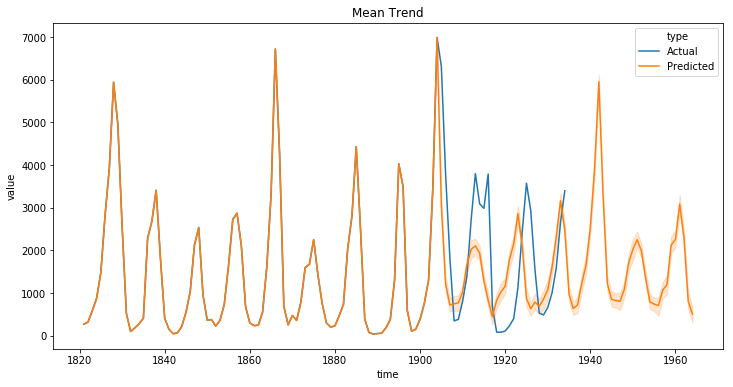

In [23]:
sns.lineplot('time', 'value', hue='type', data=res3).set_title('Mean Trend');

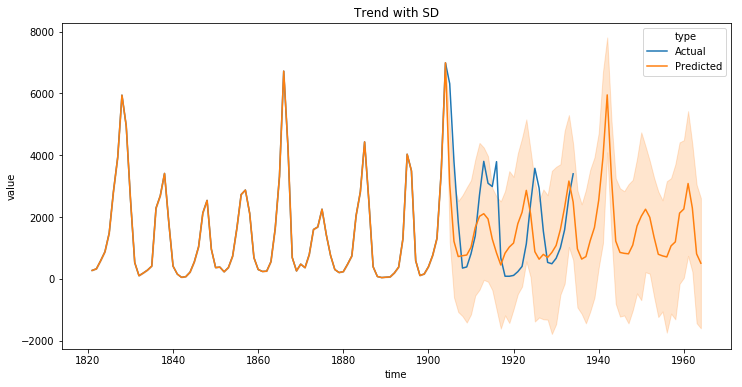

In [24]:
sns.lineplot('time', 'value', hue='type', ci='sd', data=res3).set_title('Trend with SD');

In [25]:
guide.quantiles([0.2, 0.5, 0.8])

{'nu': [tensor(2.5911, grad_fn=<AddBackward0>),
  tensor(2.8989, grad_fn=<AddBackward0>),
  tensor(3.3545, grad_fn=<AddBackward0>)],
 'sigma': [tensor(925.3611, grad_fn=<AddBackward0>),
  tensor(1055.3865, grad_fn=<AddBackward0>),
  tensor(1203.6821, grad_fn=<AddBackward0>)],
 'alpha': [tensor(0.0194, grad_fn=<ClampBackward>),
  tensor(0.0775, grad_fn=<ClampBackward>),
  tensor(0.2629, grad_fn=<ClampBackward>)],
 'beta': [tensor(0.3409, grad_fn=<ClampBackward>),
  tensor(0.4931, grad_fn=<ClampBackward>),
  tensor(0.6465, grad_fn=<ClampBackward>)],
 'gamma': [tensor(0.1726, grad_fn=<ClampBackward>),
  tensor(0.3871, grad_fn=<ClampBackward>),
  tensor(0.6567, grad_fn=<ClampBackward>)],
 'pow_trend': [tensor(0.0371, grad_fn=<AddBackward0>),
  tensor(0.0493, grad_fn=<AddBackward0>),
  tensor(0.0654, grad_fn=<AddBackward0>)]}

### Model 2: Noise varies with time (tau_var is non-zero)

In [51]:
def model_sgt_3(y, seasonality, predict_fn=None, predict_ahead=0):
    """
    SGT model with time-varying noise.
    """
    if predict_fn is None:
        predict_fn = model_sgt_predict
    S = seasonality
    nu = pyro.sample('nu', dist.Uniform(2, 20))
    sigma = pyro.sample('sigma', dist.HalfCauchy(20.))
    # NOTE: prior is changed to bias alpha --> 0.
    alpha = pyro.sample('alpha', dist.Beta(1., 20.)) 
    beta = pyro.sample('beta', dist.Beta(2., 2.))
    gamma = pyro.sample('gamma', dist.Beta(2., 2.))
    pow_trend = pyro.sample('pow_trend', dist.HalfNormal(0.2))
    pow_var = pyro.sample('pow_var', dist.HalfNormal(0.2))
    obs_window = pyro.plate('obs_window', len(y))
    s = [torch.tensor(1.)] * len(y)
    l = [torch.tensor(0.)] * len(y)
    l[0] = y[0]
    y_hat = y.new_zeros((len(y),) + alpha.shape)
    y_hat[0].fill_(y[0])
    for i in range(1, len(y)):
        seasonality_idx = get_seasonality_lookup_idx(i-1, S, i)
        s_i = s[seasonality_idx]
        assert (s_i > 0).all()
        l[i] = alpha * (y[i] / s_i) + (1 - alpha) * l[i - 1]
        assert (l[i] > 0).all(), "alpha: {}".format(alpha)
        s[i] = beta * (y[i] / l[i]) + (1 - beta) * s_i
        y_hat[i] = (l[i - 1] + gamma * l[i - 1] ** pow_trend) * s_i 
        
    sigma_hat = sigma * y_hat ** pow_var
    with obs_window:
        pyro.sample('y', dist.StudentT(nu, y_hat, sigma_hat), obs=y)
        
    if predict_ahead > 0:
        predict_fn(gamma, pow_trend, nu, sigma, l, s, S, predict_ahead, pow_var=pow_var)

In [52]:
pyro.clear_param_store()
pyro.set_rng_seed(5)
S = 38
guide = AutoDiagonalNormal(model_sgt_3)
opt = optim.Adam({'lr': 0.05})
svi = SVI(model_sgt_3, guide, opt, loss=Trace_ELBO())

for i in range(1000):
    loss = svi.step(y_train, S)
    if i % 50 == 0:
        print('ELBO loss: {}'.format(loss))
print('ELBO loss: {}'.format(loss))

ELBO loss: 1672.4571678638458
ELBO loss: 769.9646465182304
ELBO loss: 747.0351177453995
ELBO loss: 729.8638310432434
ELBO loss: 738.4236615896225
ELBO loss: 726.3212874531746
ELBO loss: 725.5217506885529
ELBO loss: 732.1076974868774
ELBO loss: 732.7414321899414
ELBO loss: 732.1828334331512
ELBO loss: 727.9027590751648
ELBO loss: 733.4791767597198
ELBO loss: 733.6593563556671
ELBO loss: 733.8799319267273
ELBO loss: 733.1407517194748
ELBO loss: 732.2801674604416
ELBO loss: 729.5733752250671
ELBO loss: 726.5289989709854
ELBO loss: 727.4984256029129
ELBO loss: 731.1096051335335
ELBO loss: 728.0466690659523


In [53]:
num_samples = 100
preds, l, s = predict(model_sgt_3, guide, y_train, S, future_steps=60, num_samples=num_samples)

res4 = lynx.copy()
res4['type'] = 'Actual'
l_samples = np.hstack([l.detach().cpu().numpy(), 
                      np.full((num_samples, len(preds[1]) - len(l[1])), np.nan)
                      ]).flatten()
s_samples = np.hstack([s.detach().cpu().numpy(), 
                       np.full((num_samples, len(preds[1]) - len(s[1])), np.nan)
                      ]).flatten()
df = pd.DataFrame(np.stack([
    np.tile(np.arange(1821, 1821 + len(preds[1])), num_samples), 
    preds.flatten().detach().cpu().numpy(),
    l_samples,
    s_samples,
]).T, columns=['time', 'value', 'l', 's'])
df['type'] = 'Predicted'
res4 = res4.append(df, sort=True)
res4 = res4.astype({'time': 'int32'})

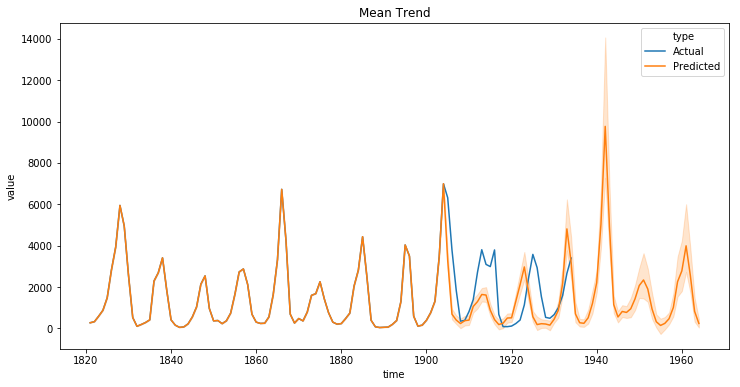

In [54]:
sns.lineplot('time', 'value', hue='type', data=res4).set_title('Mean Trend');

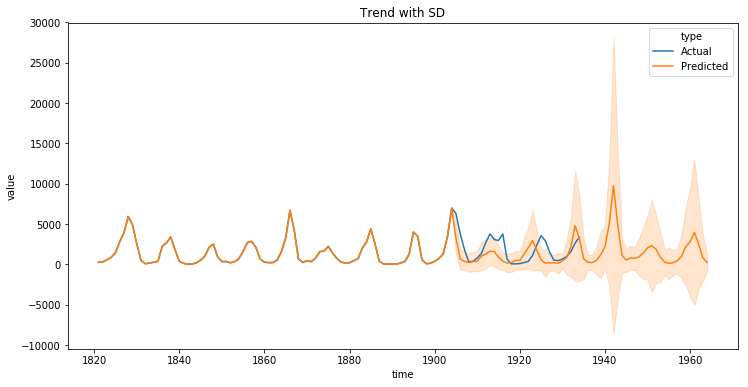

In [55]:
sns.lineplot('time', 'value', hue='type', ci='sd', data=res4).set_title('Trend with SD');

In [56]:
guide.quantiles([0.2, 0.5, 0.8])

{'nu': [tensor(4.7790, grad_fn=<AddBackward0>),
  tensor(8.2974, grad_fn=<AddBackward0>),
  tensor(13.0396, grad_fn=<AddBackward0>)],
 'sigma': [tensor(219.7516, grad_fn=<AddBackward0>),
  tensor(242.4698, grad_fn=<AddBackward0>),
  tensor(267.5366, grad_fn=<AddBackward0>)],
 'alpha': [tensor(0.0584, grad_fn=<ClampBackward>),
  tensor(0.0850, grad_fn=<ClampBackward>),
  tensor(0.1223, grad_fn=<ClampBackward>)],
 'beta': [tensor(0.7532, grad_fn=<ClampBackward>),
  tensor(0.8230, grad_fn=<ClampBackward>),
  tensor(0.8763, grad_fn=<ClampBackward>)],
 'gamma': [tensor(0.2718, grad_fn=<ClampBackward>),
  tensor(0.4851, grad_fn=<ClampBackward>),
  tensor(0.7039, grad_fn=<ClampBackward>)],
 'pow_trend': [tensor(0.0286, grad_fn=<AddBackward0>),
  tensor(0.0640, grad_fn=<AddBackward0>),
  tensor(0.1436, grad_fn=<AddBackward0>)],
 'pow_var': [tensor(0.2068, grad_fn=<AddBackward0>),
  tensor(0.2209, grad_fn=<AddBackward0>),
  tensor(0.2360, grad_fn=<AddBackward0>)]}

## Inference Using MCMC

In [32]:
from pyro.infer.mcmc import NUTS
from pyro.infer.mcmc.util import predictive
from pyro.infer.mcmc.api import MCMC

In [33]:
model = model_sgt_2  # compiling model_sgt_3 takes too long
pyro.set_rng_seed(5)
nuts_kernel = NUTS(model=model, jit_compile=True, ignore_jit_warnings=True)
num_samples = 1000
mcmc = MCMC(nuts_kernel, num_samples=num_samples//2, warmup_steps=num_samples//2, num_chains=2)
S = 38
mcmc.run(y_train, S)

In [34]:
mcmc.summary()



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         nu      3.40      2.20      2.60      2.00      5.24    452.34      1.00
      sigma   1305.89    252.61   1269.01    920.66   1707.03    404.79      1.00
      alpha      0.09      0.09      0.06      0.00      0.22    865.73      1.00
       beta      0.50      0.23      0.49      0.12      0.86    713.20      1.00
      gamma      0.50      0.22      0.50      0.13      0.84    625.87      1.00
  pow_trend      0.17      0.13      0.13      0.00      0.35    692.76      1.00




In [35]:
samples = mcmc.get_samples()
predictions = predictive(model_sgt_2, samples, y_train, S, predict_ahead=60, return_sites=['l', 's', 'y', 'y_pred'])

l, s, preds = predictions['l'], predictions['s'], torch.cat([predictions['y'], predictions['y_pred']], 1)

res5 = lynx.copy()
res5['type'] = 'Actual'
l_samples = np.hstack([l.detach().cpu().numpy(), 
                      np.full((num_samples, len(preds[1]) - len(l[1])), np.nan)
                      ]).flatten()
s_samples = np.hstack([s.detach().cpu().numpy(), 
                       np.full((num_samples, len(preds[1]) - len(s[1])), np.nan)
                      ]).flatten()
df = pd.DataFrame(np.stack([
    np.tile(np.arange(1821, 1821 + len(preds[1])), num_samples), 
    preds.flatten().detach().cpu().numpy(),
    l_samples,
    s_samples,
]).T, columns=['time', 'value', 'l', 's'])
df['type'] = 'Predicted'
res5 = res5.append(df, sort=True)
res5 = res5.astype({'time': 'int32'})

/Users/npradhan/workspace/pyro_dev/pyro/pyro/infer/mcmc/util.py:538: ExperimentalWarning: This function or its interface might change in the future.
  ExperimentalWarning)


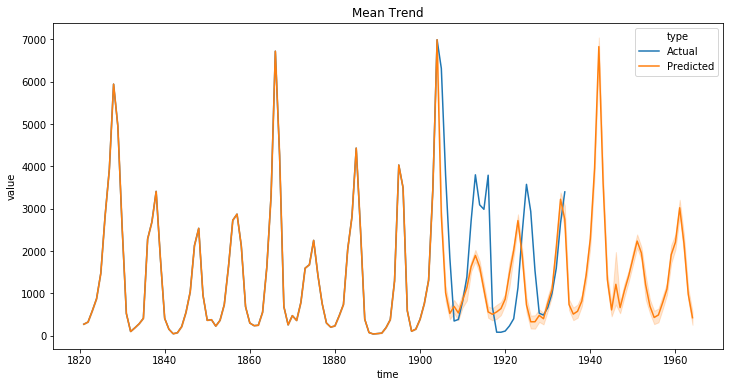

In [36]:
sns.lineplot('time', 'value', hue='type', data=res5).set_title('Mean Trend');

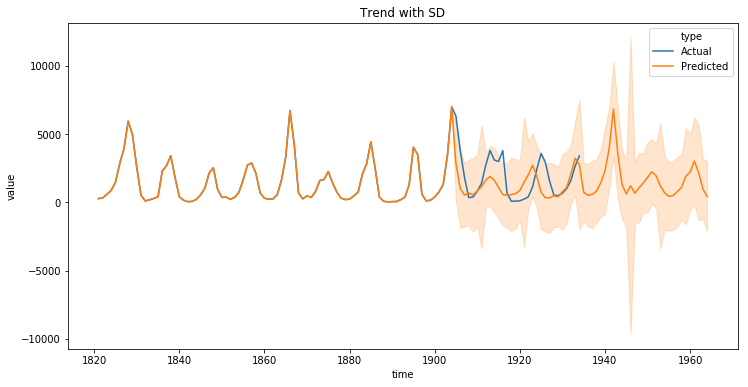

In [37]:
sns.lineplot('time', 'value', hue='type', ci='sd', data=res5).set_title('Trend with SD');

### Damping the prediction function

In [38]:
def sgt_predict_damped(gamma, pow_trend, nu, sigma, l, s, S, predict_ahead=60, pow_var=0.):
    """
    Predict `predict_ahead` time steps forward given SGT parameters.
    """
    pred_window = pyro.plate('pred_window', predict_ahead)
    obs_window = pyro.plate('obs_window_pred', len(s))
    y_pred = y.new_zeros((predict_ahead,) + gamma.shape)
    for j in range(predict_ahead):
        i = len(s) + j
        s_i = s[get_seasonality_lookup_idx(len(s), S, i)]
        l_i = l[len(s) - 1]
        damped_g = sum([gamma ** i for i in range(1, j+1)])
        y_pred[j] = (l_i + damped_g * l_i ** pow_trend) * s_i
    with obs_window:
        pyro.sample('s', dist.Delta(torch.stack(s, -1)))  # For plotting
        pyro.sample('l', dist.Delta(torch.stack(l, -1)))  # For plotting
    sigma_hat = sigma * y_pred ** pow_var
    with pred_window:
        pyro.sample('y_pred', dist.StudentT(df=nu, loc=y_pred, scale=sigma_hat))

In [39]:
predictions = predictive(model_sgt_2, samples, y_train, S, 
                         predict_ahead=60, 
                         return_sites=['l', 's', 'y', 'y_pred'],
                         predict_fn=sgt_predict_damped)

l, s, preds = predictions['l'], predictions['s'], torch.cat([predictions['y'], predictions['y_pred']], 1)

res6 = lynx.copy()
res6['type'] = 'Actual'
l_samples = np.hstack([l.detach().cpu().numpy(), 
                      np.full((num_samples, len(preds[1]) - len(l[1])), np.nan)
                      ]).flatten()
s_samples = np.hstack([s.detach().cpu().numpy(), 
                       np.full((num_samples, len(preds[1]) - len(s[1])), np.nan)
                      ]).flatten()
df = pd.DataFrame(np.stack([
    np.tile(np.arange(1821, 1821 + len(preds[1])), num_samples), 
    preds.flatten().detach().cpu().numpy(),
    l_samples,
    s_samples,
]).T, columns=['time', 'value', 'l', 's'])
df['type'] = 'Predicted'
res6 = res6.append(df, sort=True)
res6 = res6.astype({'time': 'int32'})

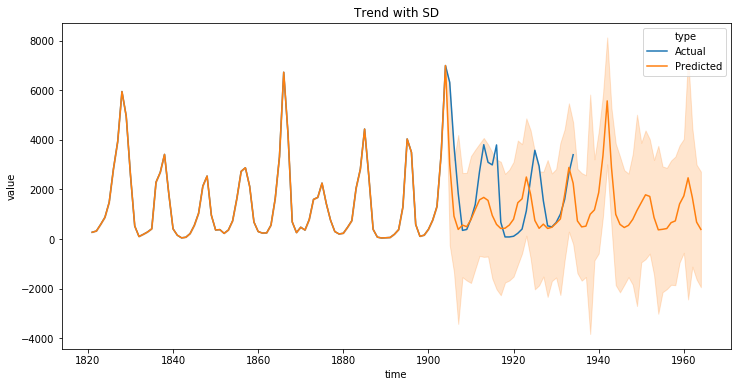

In [40]:
sns.lineplot('time', 'value', hue='type', ci='sd', data=res6).set_title('Trend with SD');

## Inference Using SVGD

In [41]:
from pyro.infer.svgd import *

### Model sgt_2

In [42]:
pyro.clear_param_store()
pyro.set_rng_seed(3)
kernel = RBFSteinKernel()
opt = optim.Adam({"lr": 0.05})
num_particles = 100
svgd = SVGD(model_sgt_2, kernel, opt, num_particles=num_particles, max_plate_nesting=1)
S = 38

for i in range(1500):
    loss = svgd.step(y_train, S)
    if i % 100 == 0:
        print('Itr: {}, Mean sq gradients: {}'.format(i, loss))
print('Itr: {}, Mean sq gradients: {}'.format(i, loss))

Itr: 0, Mean sq gradients: {'nu': 8979673.0, 'sigma': 18903322.0, 'alpha': 1862027.0, 'beta': 9095666.0, 'gamma': 8806307.0, 'pow_trend': 2736331.0}
Itr: 100, Mean sq gradients: {'nu': 198383.6875, 'sigma': 413616.875, 'alpha': 33330.6328125, 'beta': 149794.40625, 'gamma': 157048.71875, 'pow_trend': 45102.76171875}
Itr: 200, Mean sq gradients: {'nu': 55579.4609375, 'sigma': 27789.732421875, 'alpha': 44956.55859375, 'beta': 88476.21875, 'gamma': 124626.28125, 'pow_trend': 51592.01171875}
Itr: 300, Mean sq gradients: {'nu': 8161.18310546875, 'sigma': 8526.8916015625, 'alpha': 4032.491943359375, 'beta': 17476.8359375, 'gamma': 23758.751953125, 'pow_trend': 4056.931640625}
Itr: 400, Mean sq gradients: {'nu': 5757.43017578125, 'sigma': 2627.451904296875, 'alpha': 3447.6416015625, 'beta': 8602.9873046875, 'gamma': 9928.5234375, 'pow_trend': 4455.720703125}
Itr: 500, Mean sq gradients: {'nu': 8207.5390625, 'sigma': 1763.8131103515625, 'alpha': 3859.98291015625, 'beta': 12276.7177734375, 'gamm

In [43]:
particles = svgd.get_named_particles()
particles = {k: v.squeeze(-1) for k, v in particles.items()}
num_samples = num_particles
predictions = predictive(model_sgt_2, particles, y_train, S, predict_ahead=60, 
                         return_sites=['l', 's', 'y', 'y_pred'])

s, l = predictions['s'], predictions['l']
preds = torch.cat([predictions['y'], predictions['y_pred']], 1)

res7 = lynx.copy()
res7['type'] = 'Actual'
l_samples = np.hstack([l.squeeze(-1).detach().cpu().numpy(), 
                      np.full((num_samples, len(preds[1]) - len(l[1])), np.nan)
                      ]).flatten()
s_samples = np.hstack([s.squeeze(-1).detach().cpu().numpy(), 
                       np.full((num_samples, len(preds[1]) - len(s[1])), np.nan)
                      ]).flatten()
df = pd.DataFrame(np.stack([
    np.tile(np.arange(1821, 1821 + len(preds[1])), num_samples), 
    preds.flatten().detach().cpu().numpy(),
    l_samples,
    s_samples,
]).T, columns=['time', 'value', 'l', 's'])
df['type'] = 'Predicted'
res7 = res7.append(df, sort=True)
res7 = res7 .astype({'time': 'int32'})
for k, v in particles.items():
    print("{} mean - {}".format(k, v.mean(0)))

nu mean - 9.038777351379395
sigma mean - 1350.615966796875
alpha mean - 0.12572596967220306
beta mean - 0.40325823426246643
gamma mean - 0.37926071882247925
pow_trend mean - 0.37170541286468506


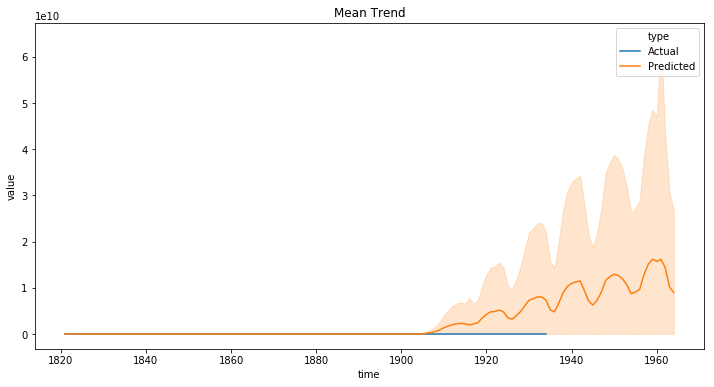

In [44]:
sns.lineplot('time', 'value', hue='type', data=res7).set_title('Mean Trend');

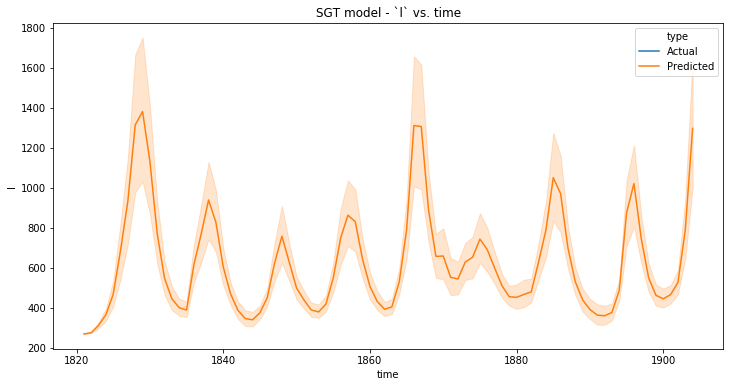

In [45]:
sns.lineplot('time', 'l', data=res7, hue='type').set_title('SGT model - `l` vs. time');

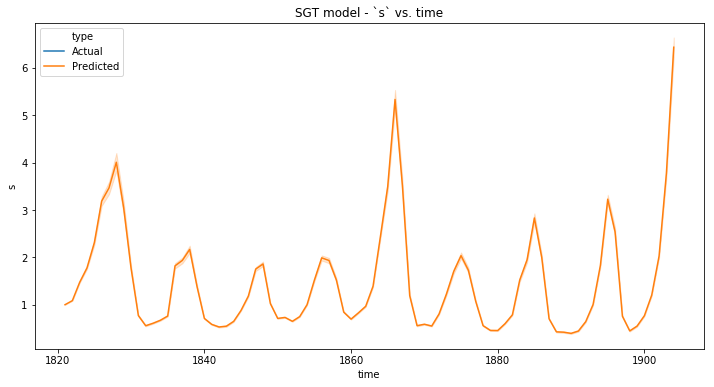

In [46]:
sns.lineplot('time', 's', data=res6, hue='type').set_title('SGT model - `s` vs. time');

### Model sgt_3

In [60]:
pyro.clear_param_store()
pyro.set_rng_seed(5)
kernel = RBFSteinKernel()
opt = optim.Adam({"lr": 0.05})
num_particles = 100
svgd = SVGD(model_sgt_3, kernel, opt, num_particles=num_particles, max_plate_nesting=1)
S = 38

for i in range(1200):
    loss = svgd.step(y_train, S)
    if i % 100 == 0:
        print('Itr: {}, Mean sq gradients: {}'.format(i, loss))
print('Itr: {}, Mean sq gradients: {}'.format(i, loss))

Itr: 0, Mean sq gradients: {'nu': 12909972.0, 'sigma': 13219757.0, 'alpha': 9229805.0, 'beta': 10273855.0, 'gamma': 10757856.0, 'pow_trend': 20823266.0, 'pow_var': 25324350.0}
Itr: 100, Mean sq gradients: {'nu': 101402.9921875, 'sigma': 57050.84375, 'alpha': 53823.91015625, 'beta': 76480.2265625, 'gamma': 68908.6015625, 'pow_trend': 95754.78125, 'pow_var': 150753.25}
Itr: 200, Mean sq gradients: {'nu': 3274.50634765625, 'sigma': 7210.4326171875, 'alpha': 1270.9158935546875, 'beta': 3138.506591796875, 'gamma': 3650.453125, 'pow_trend': 812.15283203125, 'pow_var': 1305.13134765625}
Itr: 300, Mean sq gradients: {'nu': 842.854736328125, 'sigma': 1807.6044921875, 'alpha': 155.22064208984375, 'beta': 783.3128662109375, 'gamma': 694.47265625, 'pow_trend': 894.39697265625, 'pow_var': 847.93115234375}
Itr: 400, Mean sq gradients: {'nu': 341.78851318359375, 'sigma': 857.4369506835938, 'alpha': 91.5595932006836, 'beta': 283.0376892089844, 'gamma': 265.1249084472656, 'pow_trend': 152.1263580322265

In [64]:
particles = svgd.get_named_particles()
particles = {k: v.squeeze(-1) for k, v in particles.items()}
num_samples = num_particles
predictions = predictive(model_sgt_2, particles, y_train, S, predict_ahead=60, 
                         return_sites=['l', 's', 'y', 'y_pred'],
                         predict_fn=sgt_predict_damped)

s, l = predictions['s'], predictions['l']
preds = torch.cat([predictions['y'], predictions['y_pred']], 1)

res8 = lynx.copy()
res8['type'] = 'Actual'
l_samples = np.hstack([l.squeeze(-1).detach().cpu().numpy(), 
                      np.full((num_samples, len(preds[1]) - len(l[1])), np.nan)
                      ]).flatten()
s_samples = np.hstack([s.squeeze(-1).detach().cpu().numpy(), 
                       np.full((num_samples, len(preds[1]) - len(s[1])), np.nan)
                      ]).flatten()
df = pd.DataFrame(np.stack([
    np.tile(np.arange(1821, 1821 + len(preds[1])), num_samples), 
    preds.flatten().detach().cpu().numpy(),
    l_samples,
    s_samples,
]).T, columns=['time', 'value', 'l', 's'])
df['type'] = 'Predicted'
res8 = res8.append(df, sort=True)
res8 = res8.astype({'time': 'int32'})
for k, v in particles.items():
    print("{} mean - {}".format(k, v.mean(0)))

nu mean - 11.611778259277344
sigma mean - 126.64093017578125
alpha mean - 0.2757279872894287
beta mean - 0.4732997417449951
gamma mean - 0.4407709538936615
pow_trend mean - 0.5412539839744568
pow_var mean - 0.6516194343566895


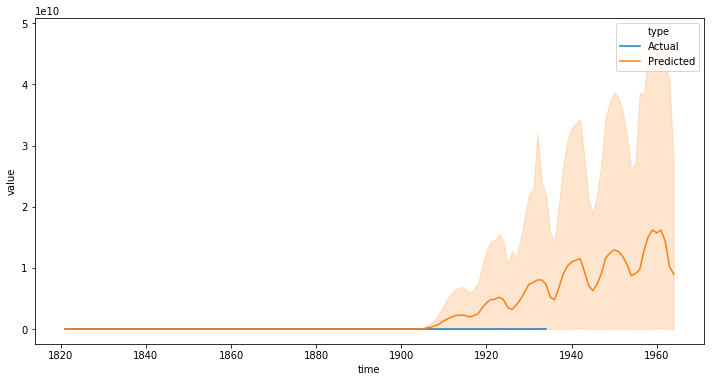

In [65]:
sns.lineplot('time', 'value', hue='type', data=res7);